In [1]:
!pwd

/home/jobquiroz/full_stack_deep_learning/lab02/notebooks


In [2]:
# Fixing path
import os

os.getcwd()   # Verify where it is right now...

'/home/jobquiroz/full_stack_deep_learning/lab02/notebooks'

In [3]:
# Solution, go to lab directory:
os.chdir('/home/jobquiroz/full_stack_deep_learning/lab02/')

In [4]:
os.listdir()

['text_recognizer', 'notebooks', '.ipynb_checkpoints']

## PyTorch Lightning

In [5]:
import pytorch_lightning as pl

version = pl.__version__

docs_url = f"https://pytorch-lightning.readthedocs.io/en/{version}/"  # version can also be latest, stable
docs_url

'https://pytorch-lightning.readthedocs.io/en/1.6.3/'

### `pl.LightningModule`

In [6]:
import torch

issubclass(pl.LightningModule, torch.nn.Module)

True

In [17]:
from text_recognizer.lit_models import BaseLitModel

In [18]:
class LinearRegression(pl.LightningModule):

    def __init__(self):
        super().__init__()  # just like in torch.nn.Module, we need to call the parent class __init__

        # attach torch.nn.Modules as top level attributes during init, just like in a torch.nn.Module
        self.model = torch.nn.Linear(in_features=1, out_features=1)
        # we like to define the entire model as one torch.nn.Module -- typically in a separate class

    # optionally, define a forward method
    def forward(self, xs):
        return self.model(xs)  # we like to just call the model's forward method

In [19]:
import logging  # import some stdlib components to control what's display
import textwrap
import traceback

try:  # try using the LinearRegression LightningModule defined above
    logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)  # hide some info for now

    model = LinearRegression()

    # we'll explain how the Trainer works in a bit
    trainer = pl.Trainer(gpus=int(torch.cuda.is_available()), max_epochs=1)
    trainer.fit(model=model)  

except pl.utilities.exceptions.MisconfigurationException as error:
    print("Error:", *textwrap.wrap(str(error), 80), sep="\n\t")  # show the error without raising it

finally:  # bring back info-level logging
    logging.getLogger("pytorch_lightning").setLevel(logging.INFO)

Error:
	No `training_step()` method defined. Lightning `Trainer` expects as minimum a
	`training_step()`, `train_dataloader()` and `configure_optimizers()` to be
	defined.


### Training_step

In [20]:
from typing import Tuple

def training_step(self: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
    xs, ys = batch  # unpack the batch
    outs = self(xs)  # apply the model
    loss = torch.nn.functional.mse_loss(outs, ys)  # compute the (squared error) loss
    return loss

LinearRegression.training_step = training_step

### Configure optimizers

In [22]:
def configure_optimizers(self: LinearRegression) -> torch.optim.Optimizer:
    optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)  # https://fsdl.me/ol-reliable-img
    return optimizer


LinearRegression.configure_optimizers = configure_optimizers

## `pl.Trainer`



In [23]:
trainer = pl.Trainer(max_epochs=20, gpus=int(torch.cuda.is_available()))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
class CorrelatedDataset(torch.utils.data.Dataset):

    def __init__(self, N=10_000):
        self.N = N
        self.xs = torch.randn(size=(N, 1))
        self.ys = torch.randn_like(self.xs) + self.xs  # correlated target data: y ~ N(x, 1)

    def __getitem__(self, idx):
        return (self.xs[idx], self.ys[idx])

    def __len__(self):
        return self.N


dataset = CorrelatedDataset()
tdl = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=1)

In [26]:
example_xs, example_ys = next(iter(tdl))  # grabbing an example batch to print

print("xs:", example_xs[:10], sep="\n")
print("ys:", example_ys[:10], sep="\n")

xs:
tensor([[-1.4647],
        [ 1.5247],
        [ 0.3228],
        [ 0.3341],
        [ 0.4599],
        [ 2.4992],
        [-0.1076],
        [-0.8604],
        [ 0.6806],
        [-0.2835]])
ys:
tensor([[-1.2774],
        [ 2.1730],
        [-0.1785],
        [ 0.5804],
        [-0.2740],
        [ 1.4019],
        [ 0.8990],
        [ 0.0136],
        [ 0.8030],
        [-0.6972]])


In [30]:
%matplotlib inline

<AxesSubplot:xlabel='x', ylabel='y'>

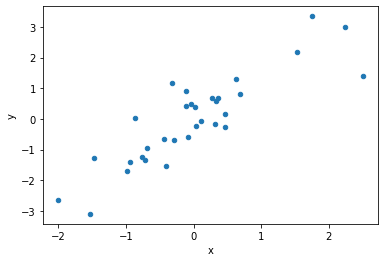

In [31]:
import pandas as pd


pd.DataFrame(data={"x": example_xs.flatten(), "y": example_ys.flatten()})\
  .plot(x="x", y="y", kind="scatter")

In [33]:
model = LinearRegression()

print("loss before training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

trainer.fit(model=model, train_dataloaders=tdl)

print("loss after training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

/home/jobquiroz/miniconda3/envs/fsdl-text-recognizer-2022/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/jobquiroz/full_stack_deep_learning/lab02/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


loss before training: 5.318972587585449
loss after training: 5.318972587585449


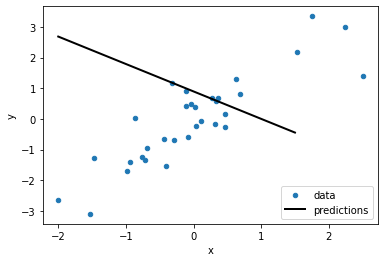

In [34]:
ax = pd.DataFrame(data={"x": example_xs.flatten(), "y": example_ys.flatten()})\
  .plot(x="x", y="y", legend=True, kind="scatter", label="data")

inps = torch.arange(-2, 2, 0.5)[:, None]
ax.plot(inps, model(inps).detach(), lw=2, color="k", label="predictions"); ax.legend();

In [37]:
pl.Trainer.__init__.__doc__.strip().split("\n")[0]

'Customize every aspect of training via flags.'

In [38]:
print(pl.Trainer.__init__.__doc__)


        Customize every aspect of training via flags.

        Args:

            accelerator: Supports passing different accelerator types ("cpu", "gpu", "tpu", "ipu", "hpu", "auto")
                as well as custom accelerator instances.

                .. deprecated:: v1.5
                    Passing training strategies (e.g., 'ddp') to ``accelerator`` has been deprecated in v1.5.0
                    and will be removed in v1.7.0. Please use the ``strategy`` argument instead.

            accumulate_grad_batches: Accumulates grads every k batches or as set up in the dict.
                Default: ``None``.

            amp_backend: The mixed precision backend to use ("native" or "apex").
                Default: ``'native''``.

            amp_level: The optimization level to use (O1, O2, etc...). By default it will be set to "O2"
                if ``amp_backend`` is set to "apex".

            auto_lr_find: If set to True, will make trainer.tune() run a learning rate finder,
 

### Training with PyLit in the FSDL Codebase

In [39]:
!ls text_recognizer/lit_models

__init__.py  __pycache__  base.py


In [40]:
!ls

lightning_logs	notebooks  text_recognizer


In [41]:
!ls training

__init__.py  run_experiment.py	util.py


In [43]:
import training.run_experiment

print(training.run_experiment.__doc__, training.run_experiment.main.__doc__)

Experiment-running framework. 
    Run an experiment.
    Sample command:
    ```
    python training/run_experiment.py --max_epochs=3 --gpus='0,' --num_workers=20 --model_class=MLP --data_class=MNIST
    ```
    For basic help documentation, run the command
    ```
    python training/run_experiment.py --help
    ```
    The available command line args differ depending on some of the arguments, including --model_class and --data_class.
    To see which command line args are available and read their documentation, provide values for those arguments
    before invoking --help, like so:
    ```
    python training/run_experiment.py --model_class=MLP --data_class=MNIST --help
    


In [44]:
# how the trainer is initialized in the training script
!grep "pl.Trainer.from" training/run_experiment.py

    trainer = pl.Trainer.from_argparse_args(args, callbacks=callbacks, logger=logger)


In [53]:
# displays the first few flags for controlling the Trainer from the command line
!python training/run_experiment.py --help | grep "pl.Trainer" -A 24

pl.Trainer:
  --logger [LOGGER]     Logger (or iterable collection of loggers) for
                        experiment tracking. A ``True`` value uses the default
                        ``TensorBoardLogger``. ``False`` will disable logging.
                        If multiple loggers are provided and the `save_dir`
                        property of that logger is not set, local files
                        (checkpoints, profiler traces, etc.) are saved in
                        ``default_root_dir`` rather than in the ``log_dir`` of
                        any of the individual loggers. Default: ``True``.
  --checkpoint_callback [CHECKPOINT_CALLBACK]
                        If ``True``, enable checkpointing. Default: ``None``.
                        .. deprecated:: v1.5 ``checkpoint_callback`` has been
                        deprecated in v1.5 and will be removed in v1.7. Please
                        consider using ``enable_checkpointing`` instead.
  --enable_checkpointing [ENAB

### LightningDataModule

In [54]:
print(pl.LightningDataModule.__doc__)

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main
    advantage is consistent data splits, data preparation and transforms across models.

    Example::

        class MyDataModule(LightningDataModule):
            def __init__(self):
                super().__init__()
            def prepare_data(self):
                # download, split, etc...
                # only called on 1 GPU/TPU in distributed
            def setup(self, stage):
                # make assignments here (val/train/test split)
                # called on every process in DDP
            def train_dataloader(self):
                train_split = Dataset(...)
                return DataLoader(train_split)
            def val_dataloader(self):
                val_split = Dataset(...)
                return DataLoader(val_split)
            def test_dataloader(self):
                test_split = Dataset(...)
                return DataLoader(test_split)
            def

In [55]:
import math


class CorrelatedDataModule(pl.LightningDataModule):

    def __init__(self, size=10_000, train_frac=0.8, batch_size=32):
        super().__init__()  # again, mandatory superclass init, as with torch.nn.Modules

        # set some constants, like the train/val split
        self.size = size
        self.train_frac, self.val_frac = train_frac, 1 - train_frac
        self.train_indices = list(range(math.floor(self.size * train_frac)))
        self.val_indices = list(range(self.train_indices[-1], self.size))

        # under the hood, we've still got a torch Dataset
        self.dataset = CorrelatedDataset(N=size)

In [56]:
def setup(self, stage=None):  # prepares state that needs to be set for each GPU on each node
    if stage == "fit" or stage is None:  # other stages: "test", "predict"
        self.train_dataset = torch.utils.data.Subset(self.dataset, self.train_indices)
        self.val_dataset = torch.utils.data.Subset(self.dataset, self.val_indices)

def prepare_data(self):  # prepares state that needs to be set once per node
    pass  # but we don't have any "node-level" computations


CorrelatedDataModule.setup, CorrelatedDataModule.prepare_data = setup, prepare_data

In [57]:
def train_dataloader(self: pl.LightningDataModule) -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(self.train_dataset, batch_size=32)

def val_dataloader(self: pl.LightningDataModule) -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(self.val_dataset, batch_size=32)

CorrelatedDataModule.train_dataloader, CorrelatedDataModule.val_dataloader = train_dataloader, val_dataloader

In [58]:
model = LinearRegression()
datamodule = CorrelatedDataModule()

dataset = datamodule.dataset

print("loss before training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

trainer = pl.Trainer(max_epochs=10, gpus=int(torch.cuda.is_available()))
trainer.fit(model=model, datamodule=datamodule)

print("loss after training:", torch.mean(torch.square(model(dataset.xs) - dataset.ys)).item())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jobquiroz/miniconda3/envs/fsdl-text-recognizer-2022/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


loss before training: 1.7290900945663452


Training: 0it [00:00, ?it/s]

loss after training: 1.0625207424163818


## `pl.CallBack`


In [59]:
pl.callbacks.__all__  # builtin Callbacks from Lightning

['BackboneFinetuning',
 'BaseFinetuning',
 'Callback',
 'DeviceStatsMonitor',
 'EarlyStopping',
 'GPUStatsMonitor',
 'XLAStatsMonitor',
 'GradientAccumulationScheduler',
 'LambdaCallback',
 'LearningRateMonitor',
 'ModelCheckpoint',
 'ModelPruning',
 'ModelSummary',
 'BasePredictionWriter',
 'ProgressBar',
 'ProgressBarBase',
 'QuantizationAwareTraining',
 'RichModelSummary',
 'RichProgressBar',
 'StochasticWeightAveraging',
 'Timer',
 'TQDMProgressBar']

In [60]:
hooks = ", ".join([method for method in dir(pl.Callback) if method.startswith("on_")])
print("hooks:", *textwrap.wrap(hooks, width=80), sep="\n\t")

hooks:
	on_after_backward, on_batch_end, on_batch_start,
	on_before_accelerator_backend_setup, on_before_backward,
	on_before_optimizer_step, on_before_zero_grad, on_configure_sharded_model,
	on_epoch_end, on_epoch_start, on_exception, on_fit_end, on_fit_start,
	on_init_end, on_init_start, on_keyboard_interrupt, on_load_checkpoint,
	on_predict_batch_end, on_predict_batch_start, on_predict_end,
	on_predict_epoch_end, on_predict_epoch_start, on_predict_start,
	on_pretrain_routine_end, on_pretrain_routine_start, on_sanity_check_end,
	on_sanity_check_start, on_save_checkpoint, on_test_batch_end,
	on_test_batch_start, on_test_end, on_test_epoch_end, on_test_epoch_start,
	on_test_start, on_train_batch_end, on_train_batch_start, on_train_end,
	on_train_epoch_end, on_train_epoch_start, on_train_start,
	on_validation_batch_end, on_validation_batch_start, on_validation_end,
	on_validation_epoch_end, on_validation_epoch_start, on_validation_start


Sill Callback

In [61]:
class HelloWorldCallback(pl.Callback):

    def on_train_epoch_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule):
        print("👋 hello from the start of the training epoch!")

    def on_validation_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule):
        print("👋 hello from the end of the validation epoch!")

In [68]:
import random


def on_train_batch_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int):
        if random.random() > 0.995:
            print(f"👋 hello from inside the lucky batch, #{batch_idx}!")


HelloWorldCallback.on_train_batch_start = on_train_batch_start

In [69]:
model = LinearRegression()

datamodule = CorrelatedDataModule()

trainer = pl.Trainer(  # we instantiate and provide the callback here, but nothing happens yet
    max_epochs=10, gpus=int(torch.cuda.is_available()), callbacks=[HelloWorldCallback()])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [70]:
trainer.fit(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2     
---------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #134!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #130!
👋 hello from inside the lucky batch, #187!
👋 hello from inside the lucky batch, #220!
👋 hello from the start of the training epoch!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #231!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #96!
👋 hello from inside the lucky batch, #236!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #143!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #56!
👋 hello from inside the lucky batch, #79!
👋 hello from inside the lucky batch, #173!
👋 hello from the start of the training epoch!
👋 hello from inside the lucky batch, #205!
👋 hello from the start of the training epoch!
👋 hello from the start of the training epoch!


### `torchmetrics`

In [72]:
import torchmetrics

tm_version = torchmetrics.__version__
print("metrics:", *textwrap.wrap(", ".join(torchmetrics.__all__), width=80), sep="\n\t")

metrics:
	functional, Accuracy, AUC, AUROC, AveragePrecision, BinnedAveragePrecision,
	BinnedPrecisionRecallCurve, BinnedRecallAtFixedPrecision, BLEUScore,
	BootStrapper, CalibrationError, CatMetric, CHRFScore, CohenKappa,
	ConfusionMatrix, CosineSimilarity, TweedieDevianceScore, ExplainedVariance,
	ExtendedEditDistance, F1, F1Score, FBeta, FBetaScore, HammingDistance, Hinge,
	HingeLoss, JaccardIndex, KLDivergence, MatthewsCorrcoef, MatthewsCorrCoef,
	MaxMetric, MeanAbsoluteError, MeanAbsolutePercentageError, MeanMetric,
	MeanSquaredError, MeanSquaredLogError, Metric, MetricCollection, MetricTracker,
	MinMaxMetric, MinMetric, MultioutputWrapper,
	MultiScaleStructuralSimilarityIndexMeasure, PearsonCorrcoef, PearsonCorrCoef,
	PermutationInvariantTraining, PIT, Precision, PrecisionRecallCurve, PSNR,
	PeakSignalNoiseRatio, R2Score, Recall, RetrievalFallOut, RetrievalHitRate,
	RetrievalMAP, RetrievalMRR, RetrievalNormalizedDCG, RetrievalPrecision,
	RetrievalRecall, RetrievalRPrecision, ROC,

In [73]:
issubclass(torchmetrics.Metric, torch.nn.Module)

True

In [74]:
BaseLitModel.__init__??